## Image reconstruction in X-ray tomography

### Bergaoui Khalil, Hachicha Mohamed Amine



In [1]:
import os
import time
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random

### 1. X-ray Tomography

In [2]:
from scipy.io import loadmat
data_dir = './data/'

x_bar = loadmat(data_dir+'x.mat')['x']
H = loadmat(data_dir+'H.mat')['H']
M = H.shape[0]
N = x_bar.shape[0]
assert N == H.shape[1]

#Load gradient matrix
G = loadmat(data_dir+'G.mat')['G']

In [3]:
random.seed(42) # Fix random seed for reproductible results

In [4]:
from numpy.random import standard_normal
from scipy.linalg import cholesky

sigma = 1
#Use scipy's cholesky instead of numpy multivariate_normal function
#because M =16200 >> 1
l = cholesky((sigma ** 2)*np.identity(M), check_finite=False, overwrite_a=True)
w = l.dot(standard_normal(l.shape[0]))
w = np.expand_dims(w,axis=1) # This gives w of shape (M,1)

#### Noisy sinogram
$y = H\bar{x} + w$  where $\:  w\sim N(0, \sigma^{2} I_{M})\:, \sigma=1$

In [5]:
#Noisy sinogram
y = H @ x_bar 
y = y + w

In [6]:
Nx, Ny = 90, 180

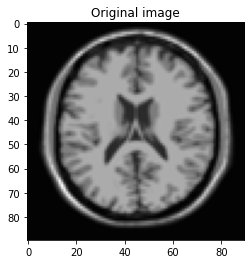

In [7]:
#Display image
def display_images(xs,titles):
    
    if len(xs)>1:
        fig, axs = plt.subplots(1,len(xs))
        for i in range(len(xs)):
            x_2D = xs[i].reshape((Nx,Nx), order= 'F')
            axs[i].imshow(x_2D,cmap='gray')
            axs[i].set_title(titles[i])
            
    else:
        x_2D = xs[0].reshape((Nx,Nx), order= 'F')
        plt.imshow(x_2D,cmap='gray')
        plt.title(titles[0])
    
display_images([x_bar],['Original image'])

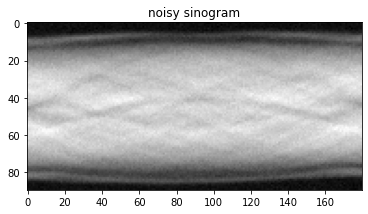

In [8]:
#Display noisy sinogram
y_2D = y.reshape((Nx,Ny), order= 'F')
plt.imshow(y_2D,cmap='gray')
tt= plt.title('noisy sinogram')

### 2.Optimization problem

We focus on thefollowing penalized least-squares criterion :
    
$$\forall x\in \mathbb{R}^N, \; f(x) = \frac{1}{2}{\lVert Hx - y \rVert}^2 + \lambda r(x)$$

$$  \text{where,} \forall x\in \mathbb{R}^N, \forall u\in \mathbb{R}\
\left\{
    \begin{array}{ll}
          r(x) = \sum_{n=1}^{2N}\psi([Gx]^n)\\
         \psi(u) = (1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}\\
         G \in \mathbb{R}^{2N} \text{, is the concatenation of the horizontal and vertical gradient}
    \end{array}
\right.
$$


**2.2** The function $f$ is differentiable and the gradient is given by:


$$\nabla f(x) = H^T(Hx-y) + \lambda \nabla r(x)$$

where: $r(x) = \sum_{n=1}^{2N}\psi([Gx]^n) = \sum_{n=1}^{2N}\psi(h_n(x)) \; h_n(x) = ([Gx]^n)_{1\leq n\leq 2N}$. 

By composition formula, we can express:

$\nabla r(x) = \sum_{n=1}^{2N}\psi^{'}(h_n(x)) \nabla h_n(x)$

with $\nabla h_n(x) = \nabla ([Gx]^n)_{1\leq n\leq 2N} = G^Te_n$
and the derivative of $\psi$ given by : $\; \psi^{'} (u) = \frac{1}{\delta^2}.\frac{u}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}} \;, \forall u \in \mathbb{R}$.

Finally we can get $\nabla r(x) =G^T(\psi^{'} ([Gx]^n)_{1\leq n\leq 2N}$ and the gradient of $f$ is: 

$$\nabla f(x) = H^T(Hx-y) + \lambda G^T(\psi^{'} ([Gx]^n)_{1\leq n\leq 2N}$$

**2.3** According to the above formula, the gradient $\nabla f$ is differentiable and we can compute the Hessian matrix of our optimization function $f$. 

By noting $h(x) = ([Gx]^n)_{1\leq n\leq 2N}$ , we get:

$$\nabla^2 f = H^TH + \lambda G^TJ_h(x) \; \; $$


$$ 
\left\{
    \begin{array}{ll}
         J_h(x) = diag(\psi^{''}([Gx]^n)_{1\leq n\leq 2N}G \text{, is the Jacobian matrix associated with }h \\
         \forall u\in \mathbb{R}, \psi^{''}(u)= \frac{1}{\delta^2}.\frac{1}{(1+\frac{u^2}{\delta^2})^{{\frac{3}{2}}}}
    \end{array}
\right.
$$



Given that $\forall u\in \mathbb{R}, |\psi^{''}(u)| \leq\frac{1}{\delta^2}$ , we can deduce that $\lVert G^TJ_h(x)  \rVert  = \lVert G^T*diag(\psi^{''}([Gx]^n)_{1\leq n\leq 2N}*G  \rVert \leq \frac{1}{\delta^2} \lVert G^TG \rVert $.

Thus, we deduce $\lVert\nabla^2 f\rVert \leq \lVert H^TH\rVert + \frac{\lambda}{\delta^2} \lVert G^TG\rVert $, 
so $f$ has Lipschitzian gradient with constant: $$ L = \lVert H^TH \rVert + \frac{\lambda}{\delta^2}.\lVert \| G^TG \rVert$$


In [9]:
from scipy.sparse import linalg
lamda, delta = 0.13, 0.02
v1 = scipy.sparse.linalg.eigsh(np.transpose(H)@H)[0].max()
v2 = (lamda/np.power(delta,2))*scipy.sparse.linalg.eigs(np.transpose(G)@G)[0].max()
L = np.real(v1 + v2) #Lipschitz gradient constant

### 3.Optimization algorithms

#### 3.1 Gradient Descent algorithm

The gradient descent algorithm can be formulated as follows:


$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
          x_0 \in\mathbb{R^n} \text{ Given initial point}\\
         x_{n+1} = x_n - \frac{1}{L}\nabla f(x)
    \end{array}
\right.
$$

where:

- $ L = \left \| H^TH \right \| + \frac{\lambda}{\delta^2}.\left \| G^TG \right \| $ : Lipschitz constant of the gradient.

- $\nabla f(x) = H^T(Hx-y) + \lambda G^T(\psi^{'} ([Gx]^n)_{1\leq n\leq 2N}$

- $\forall u \in \mathbb{R},\; \psi^{'} (u) = \frac{1}{\delta^2}.\frac{u}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}$


In [10]:
f_dict = {}
time_dict = {}
x_pred_dict = {}

In [11]:
def psi(u, delta=delta):
    """
    """
    return np.sqrt(1+(u**2)/(delta**2))

def psi_prime(u, delta=delta):
    """
    Derivative of the above psi
    """
    return (u/(delta**2))/psi(u)

def f(x, lamda=lamda, delta=delta):
    return 0.5 * np.linalg.norm(H @ x - y)**2 + lamda * np.sum(psi(G @ x, delta=delta))

def nablaf(x_n,G,H,K,delta,lamda):
    """
    Compute gradient of f at point x
    """
    g = G@x_n
 
    grad = H.T@((H@x_n) - y) + lamda * G.T@psi_prime(g, delta=delta)
    
    return grad

def gradient_descent(max_iter, eps):
    
    gd_error =[]
    K = H.T@y
    x_0 = np.ones(x_bar.shape)
    x_n = x_0
    f_list = [f(x_n)]
    start_time = time.time()
    time_list = [0]
    for i in range(max_iter):        
        
        grad = nablaf(x_n,G,H,K,delta,lamda)
        if np.linalg.norm(grad) < eps:
            print('breaking after {} iterations'.format(i+1))
            break
            
        if (i+1)%500 == 0:
            print(f"Iteration {i+1},  Gradient Norm: {np.linalg.norm(grad)}")
        
        x_n = x_n - (1/L)*grad
        
        f_list.append(f(x_n))
        time_list.append(time.time() - start_time)
    print(f'Done after {i+1} iterations.')        
    return x_n.squeeze(), f_list, time_list

Iteration 500,  Gradient Norm: 31.425644987211516
Iteration 1000,  Gradient Norm: 6.23452495511505
Iteration 1500,  Gradient Norm: 1.9242060259038676
Iteration 2000,  Gradient Norm: 0.6931167169511508
Iteration 2500,  Gradient Norm: 0.27527578209248343
Iteration 3000,  Gradient Norm: 0.11701052275125924
Iteration 3500,  Gradient Norm: 0.05213978948471666
Iteration 4000,  Gradient Norm: 0.024034993122532215
Iteration 4500,  Gradient Norm: 0.01136548743339249
breaking after 4659 iterations
Done after 4659 iterations.
Results saved !
Reconstruction error: 0.10617230468466828


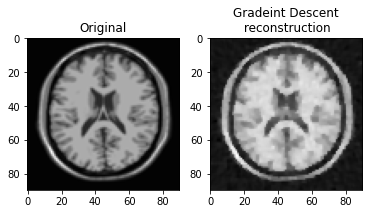

In [12]:
eps0 = np.sqrt(N) * 1e-4
x_grad, f_list, time_list = gradient_descent(max_iter=10000, eps=eps0)

x_pred_dict['GD'] = x_grad
f_dict['GD'] = f_list
time_dict['GD'] = time_list
print('Results saved !')
rec_error = np.linalg.norm(x_grad.reshape(x_bar.shape[0], -1) - x_bar, 1)/np.linalg.norm(x_bar, 1)
print('Reconstruction error: {}'.format(rec_error))
display_images([x_bar,x_grad],['Original', 'Gradeint Descent\n reconstruction'])

Qualitatively, the reconstructed image appears a bit blurry. Moreover, the central image and the image overall has a higehr contrast compared to the original one.

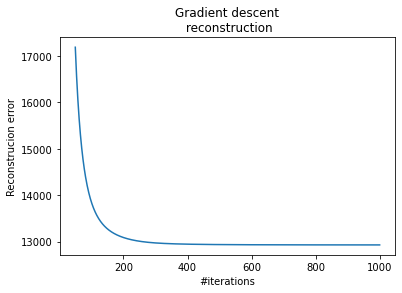

In [13]:
plt.plot(range(50, 1000), f_list[50:1000])
plt.title('Gradient descent\n reconstruction')
plt.xlabel('#iterations')
ll=plt.ylabel('Reconstrucion error')

The algorithm converges after $\approx 400$ iterations. 

#### 3.2 MM quadratic algorithm

To find a quadratic majorant for the penalized least-squares criterion we will majorize the two terms:
    
$$\forall x\in \mathbb{R}^N, \; f(x) = \frac{1}{2}{\lVert Hx - y \rVert}^2 + \lambda r(x)$$



- Quadratic majorant for $g: x\mapsto \frac{1}{2}{\lVert Hx - y \rVert}^2$ : 

Since g is a quadratic function we can use the Hessian matrix to obtain : $g(x) \leq g(x_0)+ \nabla g(x_0)^T(x-x_0) + \frac{1}{2}(x-x_0)^T\nabla^2g(x_0)(x-x_0)$ where $\nabla^2g(x_0) = H^TH$ is the majorant matrix of g.


- Quadratic majorant for $ x\mapsto r(x) = \sum_{n=1}^{2N}\psi([Gx]^n)$ : 

For this, let us start by majorating the function $x\mapsto \psi([Gx]^n)$ for $1\leq n\leq2N$. 

$u\mapsto \psi(u) = (1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}$ is an even function such that:

   (i) $\psi$ is differentiable over $]0,+\infty[$
    
   (ii) $\psi(\sqrt.)$ is concave ovn $]0,+\infty[$ : In fact, $\forall u \in ]0,+\infty[, u\mapsto \psi(\sqrt u) = (1+\frac{u}{\delta^2})^{{\frac{1}{2}}}$ is twice differentiable such that the second derivative : $u \mapsto \frac{-1}{4\delta^4}*(1+\frac{u}{\delta^2})^{{\frac{-3}{2}}} $ is strictly negative. Therefore the function is concave.
   
   (iii) $\forall u \in [0,+\infty[,\psi^{'} (u) = \frac{1}{\delta^2}.\frac{u}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}} \geq0$
   
   (iv) $\lim_{u\to0^+} \frac{\psi^{'} (u)}{u} = \frac{1}{\delta^2} \in \mathbb{R}$ 
   
Thus, since $\forall u \in \mathbb{R},\; \psi(u) = \psi(|u|) $; we can deduce a quadratic majorant of the function $\psi$ given by:

$\forall u,v \in \mathbb{R}, \; \psi(v) \leq g(u)+ \psi^{'}(u)^T(u-v) + \frac{1}{2}w(|u|)(v-u)^2$

with $w(u) = \frac{\psi^{'} (u)}{u} =\frac{1}{\delta^2}.\frac{1}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}$

Taking $u =[Gx]^n , v = [Gx_0]^n$ and summunig over $1\leq n \leq 2N$, we can write a quadratic majorant for $r$:

$r(x) \leq r(x_0)+ \nabla r(x_0)^T(x-x_0) + \frac{1}{2}(x-x_0)^T(G^TDG)(x-x_0)$ where:

$$ 
\left\{
    \begin{array}{ll}
         \nabla r(x_0) = (\psi^{'}([Gx_0]^n)_{1\leq n\leq 2N})^TG \\
         D = diag(w([Gx_0]^n)_{1\leq n\leq 2N})\\
         w(u) = \frac{\psi^{'} (u)}{u} =\frac{1}{\delta^2}.\frac{1}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}
    \end{array}
\right.
$$


Thus we have  
$$ 
\left\{
    \begin{array}{ll}
         H^TH \text{ is a positive semi definite majorant matrix of } g \\
         G^TDG \text{ is a positive semi definite majorant matrix of } r\\
         f = g + \lambda r
    \end{array}
\right.
$$

and we can deduce $A(x_0) = H^TH + \lambda G^Tdiag(w([Gx_0]_n)_{1\leq n\leq 2N})G$ such that :

$f(x) \leq f(x_0)+ \nabla f(x_0)^T(x-x_0) + \frac{1}{2}(x-x_0)^TA(x_0)(x-x_0)$ 

#### MM quadratic algorithm formulation



Finally, the MM algorithm can be formulated as follows:

$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
          x_0 \in\mathbb{R^n} \text{ Given initial point}\\
         x_{n+1} = x_n - A(x_n)^{-1}\nabla f(x)
    \end{array}
\right.
$$

where :


- $A(x_n) = H^TH + \lambda G^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})G  \; ; \forall n \in \mathbb{N}$

- $\forall u \in \mathbb{R},\; w(u)=\psi^{'} (u) = \frac{1}{\delta^2}.\frac{u}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}$


- $\nabla f(x) = H^T(Hx-y) + \lambda G^T(\psi^{'} ([Gx]^n)_{1\leq n\leq 2N})$

In [14]:
from scipy.sparse.linalg import LinearOperator, bicg


def maj_A(x_n):
    
    #Diagonal matrix for majorant of r
    
    diag = b_(x_n)
   
    def curvature(v):
        return H.T @ H @ v + lamda * (G.T @ (diag @ (G @ v)))

    return linalg.LinearOperator((H.shape[1], H.shape[1]), matvec=curvature, rmatvec=curvature)
    
    
    
def quadratic_mm():
    K = H.T@y
    x_0 = np.ones(x_bar.shape)
    x_n = x_0

    for i in range(max_iter):
        x_n_1 =x_n
        grad = nablaf(x_n) 
        A = maj_A(x_n)
        #step = bicg(A,grad)[0].reshape(N,1)
        x_n =x_n - step
        
    return x_n
        

In [15]:
H_ = H.T @ H

def maj_A(x):
    diag = scipy.sparse.diags(1 / psi(G @ x)).tocsc()
    def curv(v):
        return H_ @ v + (lamda / (delta ** 2)) * (G.T @ (diag @ (G @ v)))
    return linalg.LinearOperator((N, N), matvec=curv, rmatvec=curv)

def quadratic_mm(max_iter=100, eps=eps0, step=1):
    x = np.zeros(H.shape[1])
    K = H.T @ y
    f_list = [f(x)]
    time_list = [0]
    start_time = time.time()
    for i in range(max_iter):
        grad_f = nablaf(x.reshape(-1, 1),G,H,K,delta,lamda)
        x -= step * linalg.bicg(maj_A(x), grad_f)[0]
        norm_grad = np.linalg.norm(grad_f)
        f_list.append(f(x.reshape(-1, 1)))
        time_list.append(time.time()-start_time)
        if (i+1)%10 == 0:
            print(f"Iteration: {i+1},   Gradient Norm: {norm_grad}")
        if norm_grad<eps:
            print(f'Algorithm converged ! Breaking after {i+1} iterations')
            break
    print(f"Done after {i+1} steps !")
    return x, f_list, time_list

Iteration: 10,   Gradient Norm: 19.691394629739754
Iteration: 20,   Gradient Norm: 2.5948790271034294
Iteration: 30,   Gradient Norm: 0.5983691184182003
Iteration: 40,   Gradient Norm: 0.17176105255385862
Iteration: 50,   Gradient Norm: 0.05503182046868913
Iteration: 60,   Gradient Norm: 0.01870294079130873
Algorithm converged ! Breaking after 67 iterations
Done after 67 steps !
Results have been saved !
Reconstruction error: 0.10617254899391214


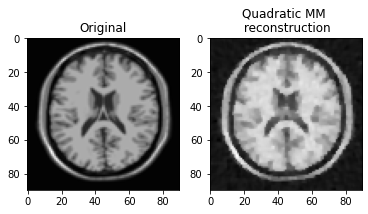

In [16]:
x_qmm, f_list, time_list = quadratic_mm(max_iter=100, eps=eps0)

x_pred_dict['QMM'] = x_qmm
f_dict['QMM'] = f_list
time_dict['QMM'] = time_list
print('Results have been saved !')

rec_error = np.linalg.norm(x_qmm.reshape(x_bar.shape[0], -1) - x_bar, 1)/np.linalg.norm(x_bar, 1)
print('Reconstruction error: {}'.format(rec_error))
display_images([x_bar,x_qmm.reshape(-1,1)],['Original', 'Quadratic MM \n reconstruction'])

We get barely the same reconstruction error as with Gradient Descent.

#### 3.3 3MG algorithm


Using subspace strategy, we will implement the following MM Memory Gradient scheme:


$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
          x_0 \in\mathbb{R^n} \; D_0 = -\nabla f(x_0) \\
         x_{n+1} = x_n +D_nu_n\\
         D_n = [-\nabla f(x_n)|x_n - x_{n-1}]\\
         u_n = -(D_n^TA(x_n)D_n)^{\dagger}D_n^T\nabla f(x_n)
    \end{array}
\right.
$$

where :


- $A(x_n) = H^TH + \lambda G^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})G  \; ; \forall n \in \mathbb{N}$


- $\forall u \in \mathbb{R},\; w(u)=\psi^{'} (u) = \frac{1}{\delta^2}.\frac{u}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}$


- $\nabla f(x) = H^T(Hx-y) + \lambda G^T(\psi^{'} ([Gx]^n)_{1\leq n\leq 2N})$



In [17]:
from scipy.sparse import csc_matrix
def get_directions(n,x_n,x_n_1,grad):
    
    if n ==0:
        D = -grad
    
    else:
        D = np.zeros((grad.shape[0],2))
        D[:,0] = -grad[:,0]
        D[:,1] = x_n[:,0] - x_n_1[:,0]
    return D
        

def b_(x_n):
    d = psi_prime(G@x_n)
    return scipy.sparse.diags(d[:,0]).tocsc()

def u_(x_n, D_n, grad_f):
    
    #Majorant of g
    product1 = H @ D_n
    maj_g = product1.T @ product1
    
    
    #Diagonal matrix for majorant of r
    diag = b_(x_n)
   
    #Majorant of r
    product2 = G @ D_n
    maj_r = diag @ product2
    maj_r = product2.T @ maj_r
    
    #pseudo inverse
    matrix = maj_g + lamda*maj_r
    pseudo = scipy.linalg.pinv(matrix)
    
    #gradient
    K = H.T @ y
    #grad = nablaf(x_n) #G,H,K,delta,lamda
    memory_grad = D_n.T @ grad_f
    
    return -pseudo@memory_grad


def mm_memory_gradient(max_iter=500, eps=eps0):
    mg_error =[]
    K = H.T@y
    x_0 = np.ones(x_bar.shape)
    x_n = x_0
    x_n_1 = 0
    
    f_list = [f(x_n)]
    time_list = [0]
    
    start_time = time.time()
    
    for n in range(max_iter):
        
        error = np.linalg.norm(x_n - x_bar, 1)/np.linalg.norm(x_bar, 1)
        mg_error.append(error)
        
        #Compute gradient
        grad_f = nablaf(x_n, G, H, K, delta, lamda)
        norm_grad = np.linalg.norm(grad_f)
        if norm_grad < eps:
            print('Breaking after {} iterations'.format(n+1))
            break
        #Subspace directions
        D_n = get_directions(n,x_n,x_n_1,grad_f)
        u_n = u_(x_n, D_n, grad_f)
        x_n_1 = x_n
        #Update
        x_n =x_n +D_n@u_n[:D_n.shape[1]]
        
        f_list.append(f(x_n))
        time_list.append(time.time() - start_time)
        
        if (n+1)%20 == 0:
            print(f"Iteration: {n+1},   Gradient Norm: {norm_grad}")
    print(f'Done in {n+1} iterations.')
    return x_n, mg_error, f_list, time_list
    

Iteration: 20,   Gradient Norm: 295.365484450281
Iteration: 40,   Gradient Norm: 42.568355096424305
Iteration: 60,   Gradient Norm: 9.74573167541424
Iteration: 80,   Gradient Norm: 2.239188272107026
Iteration: 100,   Gradient Norm: 0.4718912763705496
Iteration: 120,   Gradient Norm: 0.12211320853002544
Iteration: 140,   Gradient Norm: 0.03311329294968482
Breaking after 154 iterations
Done in 154 iterations.
Results have been saved !
reconstruction error: 0.10617285082995319


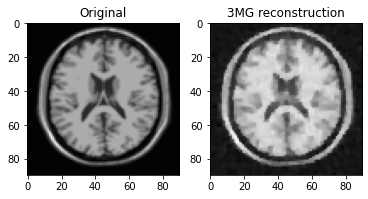

In [18]:
x_3mg, mg_error, f_list, time_list = mm_memory_gradient()

x_pred_dict['3MG'] = x_3mg
f_dict['3MG'] = f_list
time_dict['3MG'] = time_list
print('Results have been saved !')

rec_error = np.linalg.norm(x_3mg - x_bar, 1)/np.linalg.norm(x_bar, 1)
print('reconstruction error: {}'.format(rec_error))
display_images([x_bar,x_3mg],['Original', '3MG reconstruction'])

We get the same reconstruction quality as MM but much faster !

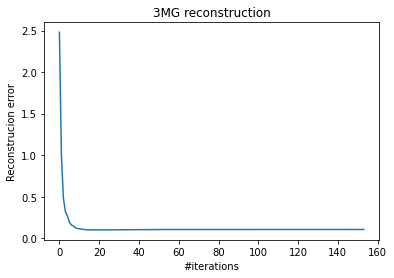

In [19]:
plt.plot(mg_error)
plt.title('3MG reconstruction')
plt.xlabel('#iterations')
ll=plt.ylabel('Reconstrucion error')

#### 3.4 Block Coordiante MM algorithm

Using the cyclic rule, we only update a given block of coordinates (chosen from J seperate blocks) at each iteration. We implement Block Coordinate MM algorithm with the following sceme:

For a fixed number of groups $J$, each block has $\approx \frac{N}{J}$ coordinates where N = 8100 is the size of the solution vector x. (For $J=1$, we recover the full MM algorithme implemented in 3.2).

$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
          x_0 \in\mathbb{R^n}  \\
         j = mod(n-1,J) +1\\
         \mathcal{G}_j = \{j.N_j -N_j +1, ..., j,N_j\}\\
         x_{n+1}[\mathcal{G}_j]= x_n[\mathcal{G}_j]- A_j(x_n)^{-1}\nabla f(x)[\mathcal{G}_j]
    \end{array}
\right.
$$


where :


- $A_j(x) = H_j^TH_j + \lambda G_j^Tdiag(w([Gx]_i)_{1\leq i\leq 2N})G)G_j \;; \forall n \in \mathbb{N} \; $ is the Truncated matrix of the quadratic majorant function


- $H_j = H[:,\mathcal{G}_j] \; , G_j = G[:,\mathcal{G}_j]$


- $\forall u \in \mathbb{R},\; w(u)=\psi^{'} (u) = \frac{1}{\delta^2}.\frac{u}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}$



- $\nabla f(x) = H^T(Hx-y) + \lambda G^T(\psi^{'} ([Gx]^n)_{1\leq n\leq 2N})$

In [20]:
def maj_Aj(x, j, Nj):
    Gj = G[:, j*Nj:(j+1)*Nj]
    Hj = H[:, j*Nj:(j+1)*Nj]
    diag_j = scipy.sparse.diags(1 / psi(Gj @ x)).tocsc()
    def curv(v):
        return Hj.T @ (Hj @ v) + (lamda / (delta ** 2)) * (Gj.T @ (diag_j @ (Gj @ v)))
    return linalg.LinearOperator((Nj, Nj), matvec=curv, rmatvec=curv)

def BMMQ(K, max_iter=1000, eps=eps0, step=1):
    K_ = H.T @ y
    Nj = N // K
    x = 0.5 * np.ones(H.shape[1])
    
    f_list = [f(x)]
    time_list = [0]
    start_time = time.time()
    for i in range(max_iter):
        j = i % K
        xj = x[j*Nj:(j+1)*Nj]
        grad_f = nablaf(x.reshape(-1, 1), G, H, K_, delta, lamda)
        norm_grad = np.linalg.norm(grad_f)
        grad_f_j = grad_f[j*Nj:(j+1)*Nj, :].reshape(-1)
        maj_j = maj_Aj(xj, j, Nj)
        xj -= step * linalg.bicg(maj_j, grad_f_j)[0]
        
        f_list.append(f(x.reshape(-1, 1)))
        time_list.append(time.time() - start_time)
        if (i+1)%(20*K) == 0:
            print(f"iter: {i+1},   gradient_norm: {norm_grad}")
        if norm_grad < eps:
            print(f"Algorithm converged! Breaking after {i+1} iterations.")
            break
    print(f"Done after {i+1} steps.")
    return x, f_list, time_list

Solving for K=1
iter: 20,   gradient_norm: 2.5948977090162932
iter: 40,   gradient_norm: 0.17175819269773263
iter: 60,   gradient_norm: 0.018702861741245563
Algorithm converged! Breaking after 67 iterations.
Done after 67 steps.
Time elapsed: 0.6939082344373068 minutes
Results have been saved !
Solving for K=2
iter: 40,   gradient_norm: 4.0281320198098225
iter: 80,   gradient_norm: 0.1613172399139706
iter: 120,   gradient_norm: 0.017595161911556294
Algorithm converged! Breaking after 134 iterations.
Done after 134 steps.
Time elapsed: 0.5975235382715861 minutes
Results have been saved !
Solving for K=3
iter: 60,   gradient_norm: 6.2001068023440356
iter: 120,   gradient_norm: 0.16794600426016476
iter: 180,   gradient_norm: 0.017653170855776962
Algorithm converged! Breaking after 200 iterations.
Done after 200 steps.
Time elapsed: 0.6111730337142944 minutes
Results have been saved !
Solving for K=5
iter: 100,   gradient_norm: 11.613669494800472
iter: 200,   gradient_norm: 0.2321800911790

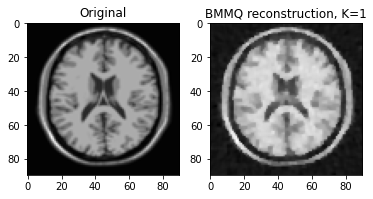

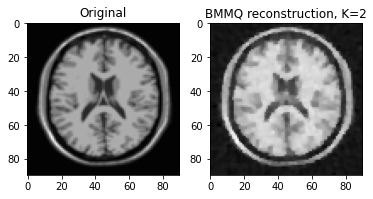

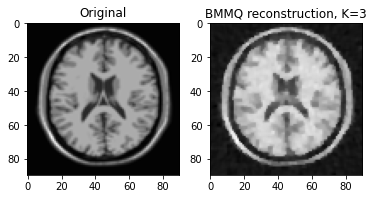

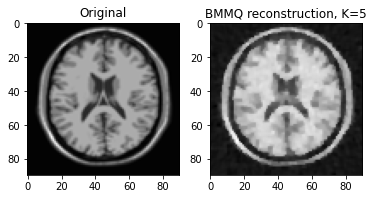

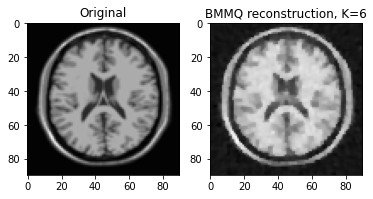

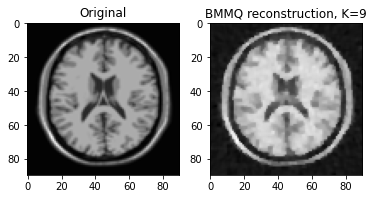

In [21]:
k_list = [1, 2, 3, 5, 6, 9]

for k in k_list:
    start_time = time.time()
    print(f'Solving for K={k}')
    x_bmmq, f_list, time_list = BMMQ(K=k)
    end_time = time.time()
    print(f"Time elapsed: {(end_time-start_time)/60} minutes")
    
    x_pred_dict['BMMQ'+str(k)] = x_bmmq
    f_dict['BMMQ'+str(k)] = f_list
    time_dict['BMMQ'+str(k)] = time_list
    print('Results have been saved !')
    display_images([x_bar,x_bmmq],['Original', f'BMMQ reconstruction, K={k}'])

#### 3.5 Parallel MM Quadratic algorithm

1. In section **3.2**, we determined the majorant matrix :

$$A(x_n) = H^TH + \lambda G^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})G  \; ; \forall n \in \mathbb{N}$$

Let us show that the given diagonal matrix $B$ verifies : $\forall x \in \mathbb{R}^{N}, \;A(x) \preceq B(x)$ 

- Majorant of $H^TH$:

Let $x \in \mathbb{R}^{N}$. We have $x^TH^THx = \sum_{m=1}^{M} ((Hx)_m)^2 = \sum_{m=1}^{M} g((Hx)_m)$ where $g : u \mapsto u^2$ is a convex function.

$\forall 1\leq m\leq M, \; g((Hx)_m) = g(\sum_{i=1}^{N} H_{m,i}x_i)$. By introducing the quantities w$_i = \frac{|H_{m,i}|}{\sum_{j=1}^{N} |H_{m,j}|}$ verifying w$_i>0$ and $\sum_{i=1}^{N} \text{w}_i = 1$, we can apply Jensen's inequality to the quantity  $g((Hx)_m)$ by convexity of $g$

$g((Hx)_m) = g(\sum_{i=1}^{N} H_{m,i}x_i)$


$\hphantom{-----}$ $= g(\sum_{i=1}^{N} \text{w}_i*(\frac{H_{m,i}x_i}{\text{w}_i}))\\
            \leq\sum_{i=1}^{N} \text{w}_i*g(\frac{H_{m,i}x_i}{\text{w}_i}) \\
            = \sum_{i=1}^{N} \frac{H_{m,i}^2}{\text{w}_i}*x_i^2 \\
            = \sum_{i=1}^{N} \mathcal{H}^{m}_i *x_i^2 , \text{where} \; \mathcal{H}^{m}_i=\frac{H_{m,i}^2}{\text{w}_i} = |H_{m,i}|\sum_{j=1}^{N}|H_{m,j}|$ 
            
Therefore: (1) $ \;x^TH^THx = \sum_{m=1}^{M}g((Hx)_m) \leq \sum_{m=1}^{M}(\sum_{i=1}^{N} \mathcal{H}^{m}_i *x_i^2) = x^Tdiag((\mathcal{H}_i^T.1)_{1\leq i\leq N})x\;$ 

i.e $H^TH \preceq diag((\mathcal{H}_i^T.1)_{1\leq i\leq N})$


- Majorant of $G^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})G$:

Let $x \in \mathbb{R}^{N}$. We have:

$x^TG^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})Gx = \sum_{m=1}^{2N} g_m((Gx)_m)$ 

where $g_m : u \mapsto w((Gx)_m)u^2$ is a convex function because of the strict positivity of function $w : u\mapsto \frac{\psi^{'} (u)}{u} =\frac{1}{\delta^2}.\frac{1}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}$ 

Similarly to the previous point in this question, we apply Jensen inequality by introducing this time the quantities w$_i = \frac{|G_{m,i}|}{\sum_{j=1}^{N} |G_{m,j}|}$ verifying w$_i>0$ and $\sum_{i=1}^{N} \text{w}_i = 1$, and we obtain :


$g_m((Gx)_m) = g_m(\sum_{i=1}^{N} G_{m,i}x_i)$

$\hphantom{-----}$ $= g_m(\sum_{i=1}^{N} \text{w}_i*(\frac{G_{m,i}x_i}{\text{w}_i}))\\
            \leq\sum_{i=1}^{N} \text{w}_i*g_m(\frac{G_{m,i}x_i}{\text{w}_i}) \\
            = \sum_{i=1}^{N} \frac{G_{m,i}^2}{\text{w}_i}*w((Gx)_m)*x_i^2 \\
            = \sum_{i=1}^{N} \mathcal{G}^{m}_i*w((Gx)_m) *x_i^2 , \text{where} \; \mathcal{G}^{m}_i=\frac{G_{m,i}^2}{\text{w}_i} = |G_{m,i}|\sum_{j=1}^{N}|G_{m,j}|$ 


Therefore: (2) $ \;x^TG^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})Gx = \sum_{m=1}^{2N} g_m((Gx)_m) \leq \sum_{m=1}^{2N}(\sum_{i=1}^{N} \mathcal{G}^{m}_i*w((Gx)_m) *x_i^2) = x^Tdiag((\mathcal{G}_i^T(w([Gx]_m)_{1\leq m\leq 2N})_{1\leq i\leq N})x\;$ 

i.e $G^Tdiag(w([Gx_n]_i)_{1\leq i\leq 2N})G \preceq diag((\mathcal{G}_i^T(w([Gx]_m)_{1\leq m\leq 2N})_{1\leq i\leq N})$

Finally by adding up the two majorants ($\lambda>0$) we obtain :


$$x^TAx \leq x^T(diag((\mathcal{H}_i^T.1)_{1\leq i\leq N} + \lambda diag((\mathcal{G}_i^T(w([Gx]_m)_{1\leq m\leq 2N})_{1\leq i\leq N}) )x = x^TBx $$

Thus proving that  $\forall x \in \mathbb{R}^{N}, \;A(x) \preceq B(x)$ .


2. Using the previous majorant matrix, the algorithm can be formulated as follows:


$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
          x_0 \in\mathbb{R}^N  \\
         x_{n+1}= x_n- B(x_n)^{-1}\nabla f(x)
    \end{array}
\right.
$$


where :


- $\nabla f(x) = H^T(Hx-y) + \lambda G^T(\psi^{'} ([Gx]^j)_{1\leq j\leq 2N})$


- $B(x_n) = diag((b_i(x_n))_{1\leq i\leq N})\;; \forall n \in \mathbb{N} \; $ 


$$  \forall 1\leq i\leq N, \
\left\{
    \begin{array}{ll}
          b_i(x_n) = \mathcal{H}_i^T.1 + \lambda \mathcal{G}_i^T(w([Gx_0]_n)_{1\leq n\leq 2N}) ; \forall n \in \mathbb{N} \\
          \forall u \in \mathbb{R}, \;w(u) = \frac{\psi^{'} (u)}{u} =\frac{1}{\delta^2}.\frac{1}{(1+\frac{u^2}{\delta^2})^{{\frac{1}{2}}}}\\
          \mathcal{H}_i \in \mathbb{R}^M ;\forall 1\leq m\leq M,\; \mathcal{H}^{m}_i = |H_{m,i}|\sum_{p=1}^{N}|H_{m,p}|\\
          \mathcal{G}_i \in \mathbb{R}^{2N} ;  \forall 1\leq k\leq 2N,\; \mathcal{G}^{k}_i = |G_{k,i}|\sum_{p=1}^{N}|G_{k,p}|
    \end{array}
\right.
$$




In [22]:
G_abs, H_abs = np.abs(G), np.abs(H)
G_sum = scipy.sparse.diags(G_abs.toarray().sum(axis=1)).tocsc()
H_sum = scipy.sparse.diags(H_abs.toarray().sum(axis=1)).tocsc()
G_cal, H_cal = G_sum @ G_abs, H_sum @ H_abs
H_cal_sum = H_cal.sum(axis=0)

def B(x):
    return np.asarray(H_cal_sum + (lamda / (delta ** 2)) * G_cal.T @ (1 / psi(G @ x))).squeeze()


def PMMQ(max_iter=6000, eps=eps0, step=1):
    K_ = H.T @ y
    x = 0.5 * np.ones(x_bar.shape)
    f_list = [f(x)]
    time_list = [0]
    start_time = time.time()
    for i in range(max_iter):
        grad_f = nablaf(x, G, H, K_, delta, lamda).squeeze()
        term = (grad_f/B(x.squeeze())).reshape(-1, 1)
        x -= step * term
        
        norm_grad_f = np.linalg.norm(grad_f)
        f_list.append(f(x))
        time_list.append(time.time()-start_time)
        if (i+1) % 400 == 0:
            print(f"Iteration {i+1}   Gradient Norm: {norm_grad_f}")
        if norm_grad_f<eps0:
            print(f"Algorithm converged ! Breaking after {i+1} steps")
            break
    return x, f_list, time_list

Solving with PMMQ
Iteration 400   Gradient Norm: 38.002487310693766
Iteration 800   Gradient Norm: 8.065209704677768
Iteration 1200   Gradient Norm: 2.545599667848864
Iteration 1600   Gradient Norm: 0.9333624454202615
Iteration 2000   Gradient Norm: 0.37603631210472643
Iteration 2400   Gradient Norm: 0.16210553313545686
Iteration 2800   Gradient Norm: 0.07332736380704928
Iteration 3200   Gradient Norm: 0.034335064682970526
Iteration 3600   Gradient Norm: 0.016497186785945212
Algorithm converged ! Breaking after 3940 steps
Time elapsed: 0.8291532198588053 minutes
Results have been saved !


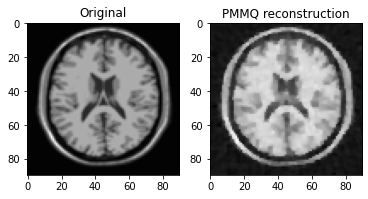

In [24]:
start_time = time.time()
print(f'Solving with PMMQ')
x_pmmq, f_list, time_list = PMMQ()
end_time = time.time()
print(f"Time elapsed: {(end_time-start_time)/60} minutes")

x_pred_dict['PMMQ'] = x_pmmq
f_dict['PMMQ'] = f_list
time_dict['PMMQ'] = time_list
print('Results have been saved !')
display_images([x_bar,x_pmmq],['Original', f'PMMQ reconstruction'])

#### 3.6 Methods Comparison :
##### For the first question, the calculation of $f(x_k)$ along the iterations is integrated in the functions. The results have been stored in the variable f_dict.

##### For each algorithm we stored the values of $f$ in the variable f_dict and the corresponding timestamp in the dictionary time_dict. Let's plot $f(x_k)$ versus time for all the algorithms. 
P.S: For BMMQ we kept K=2 which gives the fastest execution.

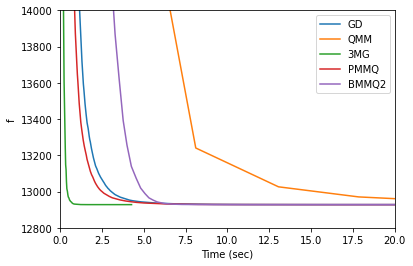

In [27]:
algos = ['GD', 'QMM', '3MG', 'PMMQ', 'BMMQ2']

for algo in algos:
    plt.plot(time_dict[algo], f_dict[algo], label=algo)
    plt.xlabel('Time (sec)')
    plt.ylabel('f')
plt.xlim(0, 20)
plt.ylim(12800, 14000)
plt.legend()
plt.show()

In [28]:
print('Time required by each algorithm to reach the convergence criterion:')
print ("{:>10} \t {:>10}".format('Algorithm', 'Time (sec)'))
for algo in algos:
    print ("{:>10} \t {:>10}".format(algo, round(time_dict[algo][-1], 2)))

Time required by each algorithm to reach the convergence criterion:
 Algorithm 	 Time (sec)
        GD 	      54.43
       QMM 	     327.12
       3MG 	       4.27
      PMMQ 	      49.74
     BMMQ2 	      34.88


### The MM Memory Gradient is the fastest algorithm.

#### Tuning the values of $\lambda$ and $\delta$ with 3MG:

In [29]:
K = H.T@y
def mm_memory_gradient(lamda, delta, max_iter=500, eps=eps0):
    
    x_0 = np.ones(x_bar.shape)
    x_n = x_0
    x_n_1 = 0
    
    for n in range(max_iter):
        
        #Compute gradient
        grad_f = nablaf(x_n, G, H, K, delta, lamda)
        norm_grad = np.linalg.norm(grad_f)
        if norm_grad < eps:
            break
        #Subspace directions
        D_n = get_directions(n,x_n,x_n_1,grad_f)
        u_n = u_(x_n, D_n, grad_f)
        x_n_1 = x_n
        #Update
        x_n =x_n +D_n@u_n[:D_n.shape[1]]
    return x_n

def SNR(x, x_bar):
    return 10 * np.log10(np.linalg.norm(x_bar)**2 / np.linalg.norm(x - x_bar)**2)

min_snr = np.inf
best_lamda = 0
best_delta = 0

lamda_list = [0.01, 0.05, 0.1, 0.13, 0.2, 0.5]
delta_list = [0.01, 0.02, 0.05, 0.1]

for lamda in lamda_list:
    for delta in delta_list:
        print(f"Solving for delta={delta} and lambda={lamda}")
        x_3mg = mm_memory_gradient(lamda, delta)
        snr = SNR(x_3mg, x_bar)
        if snr < min_snr:
            min_snr = snr
            best_lamda = lamda
            best_delta = delta
print('######## Search Done ! ########')
print('The optimal value for lambda is: ', best_lamda)
print('The optimal value for delta is: ', best_delta)
print('The optimal SNR is: ', min_snr)


Solving for delta=0.01 and lambda=0.01
Solving for delta=0.02 and lambda=0.01
Solving for delta=0.05 and lambda=0.01
Solving for delta=0.1 and lambda=0.01
Solving for delta=0.01 and lambda=0.05
Solving for delta=0.02 and lambda=0.05
Solving for delta=0.05 and lambda=0.05
Solving for delta=0.1 and lambda=0.05
Solving for delta=0.01 and lambda=0.1
Solving for delta=0.02 and lambda=0.1
Solving for delta=0.05 and lambda=0.1
Solving for delta=0.1 and lambda=0.1
Solving for delta=0.01 and lambda=0.13
Solving for delta=0.02 and lambda=0.13
Solving for delta=0.05 and lambda=0.13
Solving for delta=0.1 and lambda=0.13
Solving for delta=0.01 and lambda=0.2
Solving for delta=0.02 and lambda=0.2
Solving for delta=0.05 and lambda=0.2
Solving for delta=0.1 and lambda=0.2
Solving for delta=0.01 and lambda=0.5
Solving for delta=0.02 and lambda=0.5
Solving for delta=0.05 and lambda=0.5
Solving for delta=0.1 and lambda=0.5
######## Search Done ! ########
The optimal value for lambda is:  0.5
The optimal 